In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as slinalg
%matplotlib inline

import sys
sys.path.append('../../module')
import gym2
import util as U

In [3]:
env = gym2.make('Linear-v1')
Q = .01 * np.eye(2)
R = .01 * np.eye(1)
lam = .5

In [26]:
def array_exp(A):
    v, p = np.linalg.eig(A)
    align = np.array([[v[0], 0],[0, v[1]]])
    exp = np.exp(align)
    exp[~np.eye(exp.shape[0],dtype=bool)] = 0
    out = np.dot(np.dot(p, exp), np.linalg.inv(p))
    return out


def next_state(state, action, tau, env):
    # mean of next state when const action and tau is input
    A = env.A
    B = env.B
    eAt = array_exp(A*tau)
    A_inv = np.linalg.inv(A)
    
    integral = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
    s_prime = np.dot(eAt, state) + integral *action 
    
    return s_prime


def variance(A, D, tau):
    tmp = np.dot(array_exp(A*tau), D)
    Q = np.dot(D.reshape(2,1), D.reshape(1,2)) - np.dot(tmp, tmp)
    V = slinalg.solve_lyapunov(A, -Q)
    return V
    
    
def control_law(state, env, Q=Q, R=R, l=lam):
    A = env.A
    B = env.B
    D = env.D
    next_value_weight = 100
    
    taus = np.linspace(.01, 10., 1000)
    evaluation = np.inf
    
    # riccati
    P = slinalg.solve_continuous_are(A, B.reshape(B.shape[0],1), Q, R)
    A_inv = np.linalg.inv(A)
    
    for tau in taus:
        # calculate optimal action with fixed `tau`
        eAt = array_exp(A*tau)
        
        # ∂s'/∂u
        dsdu = np.dot(np.dot(eAt, A_inv), B) \
             - np.dot(np.dot(eAt, A_inv), np.dot(array_exp(-A*tau), B))
        # int exp(A(t-τ))Budt
        integral = dsdu

        # ∂c/∂u = first + second * u, c: instant cost
        first = 2 * np.dot(np.dot(dsdu, P), np.dot(eAt, state))
        first *= next_value_weight
        second = 2 * np.dot(np.dot(dsdu, P), integral)
        second = next_value_weight * second + 2

        # optimal action
        u = - first / second
        
        # evaluation
        s_prime = next_state(state, u, tau, env)
        V_lqr = np.dot(np.dot(s_prime, P), s_prime) + np.trace(np.dot(P, variance(A, D, tau)))
        ev = u**2 - l * tau + next_value_weight * V_lqr
        #print(s_prime, ev, [u, tau])
        if ev < evaluation:
            control = np.array([u, tau])
            evaluation = ev
    
    return control

In [21]:
state = np.array([3.,3.])
control_law(state, env)

array([-1.07805532,  2.64      ])

In [27]:
l = .5
env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = control_law(x, env)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=1)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    print(env.state, tau)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(control_law(env.state, env)[0])
states = np.array(states)
detail_states = np.array(detail_states)

[ 1.43362904 -0.19534602] 1.05
[1.65192469 0.85195777] 0.49
[1.66627113 0.51660196] 0.7100000000000001
[1.6790895  0.46303547] 0.66
[1.18972621 0.26915875] 0.65
[2.27423633 1.00612735] 0.53
[2.68381233 0.8309332 ] 0.81
[-0.04545512 -0.43618693] 0.8300000000000001
[-0.1094177  -0.19539668] 0.15000000000000002
[-0.10462888 -0.07810336] 0.17
[-0.03332206 -0.01766179] 0.17
[-0.21334828 -0.16659488] 0.17
[0.02686533 0.06329454] 0.18000000000000002
[ 0.05093603 -0.0034485 ] 0.17
[0.44686983 0.332228  ] 0.18000000000000002
[0.34996416 0.22532046] 0.01
[-0.11404545 -0.11635586] 0.2
[-0.27513349 -0.1504296 ] 0.17
[0.00822142 0.14402413] 0.18000000000000002
[0.28246161 0.24139312] 0.17
[0.13790132 0.06669522] 0.17
[0.05343169 0.00191231] 0.18000000000000002
[-0.27759099 -0.20339945] 0.18000000000000002
[-0.49554581 -0.21315412] 0.18000000000000002
[-0.67575774 -0.21814322] 0.29000000000000004
[-1.04256421 -0.37847604] 0.37
[-1.93296503 -0.83452777] 0.52
[0.66375278 1.00564487] 0.74


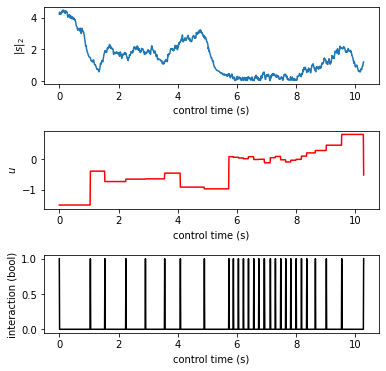

In [28]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [5]:
import warnings
warnings.filterwarnings('ignore')
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(16, activation="relu")(x)
    x1 = Dense(16, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(16, activation="relu")(x)
    x2 = Dense(16, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output_large")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor

Using TensorFlow backend.


In [6]:
actor = branch_actor((2,),(2,))
actor.compile(loss='mse', optimizer='adam')

In [29]:
# make train data
s1 = np.linspace(-7,7,100)
s2 = np.linspace(-7,7,100)
S1, S2 = np.meshgrid(s1, s2)
batch = []

for state in zip(S1.flatten(), S2.flatten()):
    state = np.array(state)
    action = control_law(state, env)
    batch.append([state, action])
    
batch = np.array(batch)

KeyboardInterrupt: 

In [ ]:
batch_size = 32

epochs = 10000
losses = []
for _ in range(epochs):
    indices = np.random.choice(range(10000),batch_size,replace=False)
    states = batch[:,0].reshape(10000,1,2)
    actions = batch[:,1]
    
    
    loss = actor.train_on_batch(states, actions)
    losses.append(loss)
    
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('actor_loss')
plt.show()


In [11]:
actor.save_weights('./saved_agent/mb_self_noisy_extend2_actor.h5')

In [17]:
l = .5
env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = actor.predict_on_batch(x.reshape(1,1,2))[0]
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau, ln=0)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    print(env.state, tau)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(control_law(env.state, env)[0])
states = np.array(states)
detail_states = np.array(detail_states)

[ 1.24869201 -0.24309629] 1.0379689
[ 0.48921019 -0.05666479] 0.40976235
[ 0.20305286 -0.03815546] 0.35145092
[0.12041491 0.02197519] 0.38321063
[ 0.05708672 -0.00618677] 0.38413194
[0.14730096 0.10122169] 0.384878
[-0.10092485 -0.16359827] 0.3829859
[0.23424096 0.25599375] 0.4260597
[-0.01764984 -0.15476049] 0.38971886
[0.22199275 0.21610051] 0.40557033
[-0.06835054 -0.18601108] 0.38801587
[0.2390037 0.2512621] 0.42309213
[-0.02209053 -0.15976488] 0.38953295
[0.21987746 0.21696986] 0.40751484
[-0.0678316  -0.18481841] 0.38803798
[0.24017072 0.25180168] 0.42273387
[-0.02112271 -0.15952708] 0.38956198
[0.2196185  0.21632821] 0.40725535
[-0.06860511 -0.18525944] 0.38801074
[0.2393726  0.25152802] 0.42299953
[-0.02166927 -0.15960759] 0.38954604
[0.2198101  0.21671905] 0.40739152
[-0.06812672 -0.184999  ] 0.38802758
[0.23985747 0.25169233] 0.42283756


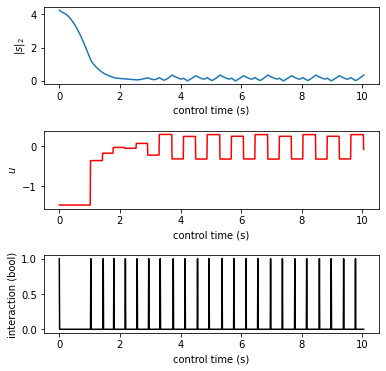

In [18]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [ ]:
with open('../csv/batch.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(batch)
    
with open('../csv/batch.csv', 'w') as f:
    reader = csv.reader(f)
    batch = np.array([r for r in reader]).astype('float')